# Deep Learning Assignment: Self-Organizing Maps and Hopfield Networks
---

# Section A: Self-Organizing Maps

**Part 1: Setup and Imports**

Import necessary libraries, set the seed for reproducability, load the Iris dataset and scale it.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

np.random.seed(42)

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

iris = datasets.load_iris()
X = iris.data  # (150, 4)
y = iris.target  # labels: 0, 1, 2

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("X_scaled shape:", X_scaled.shape)
print("X_pca shape:", X_pca.shape)

X_scaled shape: (150, 4)
X_pca shape: (150, 2)


**Part 2: Implementation of a Self-Organizing Map**

**TODO**: Complete the SOM class implementation below.

In [7]:
class SOM:
    """
    2D Self-Organizing Map with a square lattice neighborhood.

    The lattie is a square 2D grid (m, n):
      - grid coordinates (i, j)
      - grid distance: d^2 = (i - i_bmu)^2 + (j - j_bmu)^2
    """

    def __init__(self, m, n, dim, lr0=0.5, sigma0=None, n_epochs=50):
        self.m = m
        self.n = n
        self.dim = dim
        self.lr0 = lr0
        self.n_epochs = n_epochs
        self.sigma0 = sigma0 if sigma0 is not None else max(m, n) / 2.0

        # Regular 2D grid coordinates
        self.gx, self.gy = np.meshgrid(np.arange(m), np.arange(n), indexing="ij")

        #done
        # TODO: Initialize weight vectors of shape (m, n, dim) following standard normal distribution
        
        self.weights=np.random.randn(m,n,dim)

    def _learning_rate(self, epoch):
        """
        Exponential decay learning rate schedule.
        """
        # TODO: Implement exponential decay for learning rate
        # this is what we do  here :  η(t)=η0×exp(−λ/t)
        A = self.lr0 * np.exp(-epoch/self.n_epochs)
        return A 

    def _sigma(self, epoch):
        """
        Exponential decay for neighborhood radius.
        """
        # TODO: Implement exponential decay for neighborhood radius
        #σ(t)=σ0×exp(−λ/t)
        # as I said we used same logic we have aleady used in learning rate
        A = self.sigma0*np.exp(-epoch / self.n_epochs)
        return A
        

    def find_bmu(self, x):
        """
        Find Best Matching Unit (BMU) for input x.
        The BMU is the neuron closest to the given input.
        Returns:
            (i, j): indices of the BMU in the (m, n) grid.
        """
        ####################################################################
        # worst senario : using nested for and waiting all the  time      #
        #  for i in range(self.m):                                       # 
        #   for j in range(self.n):                                     #
        #   ALSO USED ANOTHER FOR FOR DIMENSION  NOT THE BEST IDEA     #
        ################################################################
        
        # TODO: Compute squared Euclidean distance to all weights and
        #       return index of minimum.
        distro=np.linalg.norm(self.weights- x, axis=2)
        min_id=np.argmin(distro)
        bmu_id=np.unravel_index( min_id, distro.shape)
        return bmu_id
        
    def _neighborhood(self, bmu, sigma):
        """
        Gaussian neighborhood on a square grid.

        Args:
            bmu   : (i, j) index of BMU
            sigma : neighborhood radius

        Returns:
            h     : (m, n) array of neighborhood values
        """
        # TODO: Implement Gaussian neighborhood function:
        #   - Compute dx, dy := differences to all grid points
        #   - d^2 = dx^2 + dy^2
        #   - h = exp( - d^2 / (2 * sigma^2) )
        distx = self.gx-bmu[0]
        disty = self.gy-bmu[1]
        dist_sq = distx**2+disty**2
        H = np.exp(-dist_sq/(2 * sigma**2))
        return H

    def train(self, data):
        """
        Train SOM on the given data with shape: (N, dim).

        High-level algorithm for each epoch:
            1. Compute current learning rate eta = self._learning_rate(epoch)
            2. Compute current neighborhood radius sigma = self._sigma(epoch)
            3. Shuffle the data indices
            4. For each sample x in the shuffled data:
                a) Find the Best Matching Unit (BMU) for x
                b) Compute the neighborhood function h around the BMU
                c) Update ALL weights using:
                        w_ij <- w_ij + eta * h_ij * (x - w_ij)
        """
        # TODO: Implement the training loop
        # ------------------------------------------------------------
        # IF neuron is far from winner or BMU , H = 0 
        # in the first state sigma and eta are both huge numbers . 
        # shuffling data help to avoid bias
        # then I need to imp a loop to update W incrementally 
        # permute 
        #-------------------------------------------------------------
        
        for epoch in range(self.n_epochs):
            lrr =self._learning_rate(epoch)
            sigma =self._sigma(epoch)
            n = len(data) 
            # I have tested data.shape[0] should work same right ?
            permut =np.random.permutation(n)
            #-----------------------
            for id_x in permut:
                x = data[id_x]
                bmu =self.find_bmu(x)
                h= self._neighborhood(bmu, sigma)
                expand_h = h.reshape(self.m,self.n,1)
                ### this is where we finally update all we have :  weights
                a = x - self.weights
                delta_W = lrr * expand_h * (a)
                #--------------------------------------------------
                self.weights += delta_W 
                

                

    def map_vects(self, data):
        """
        Map each input vector to its BMU.
        Returns:
            bmus: (N, 2) array of (i, j) indices
        """
        # list to nested array  
        # TODO: For each x in data, find BMU and store (i, j).
        bmu_list = []
        for x in data:
            bmu = self.find_bmu(x)
            bmu_list.append(bmu)
            
            
        return np.array(bmu_list)

**Part 3: Train the SOM**

Create an instance of SOM and train it on the Iris dataset. Extract weights of learned neurons and apply PCA.

In [8]:
x_neurons, y_neurons = 10, 10
som = SOM(m=x_neurons, n=y_neurons, dim=X_scaled.shape[1], lr0=0.5, n_epochs=60)
som.train(X_scaled)

weights_flat = som.weights.reshape(-1, X_scaled.shape[1])
weights_pca = pca.transform(weights_flat)

print("SOM trained.")

SOM trained.


**Part 4: Topology Visualization**

Visualize the learned topology in PCA space.

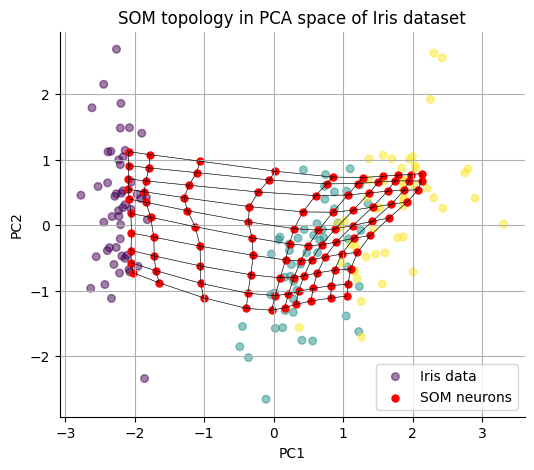

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))

# Iris data in PCA space
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", s=30, alpha=0.5, label="Iris data"
)

# Neuron positions in PCA space
W2 = weights_pca.reshape(x_neurons, y_neurons, 2)

directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
for i in range(x_neurons):
    for j in range(y_neurons):
        x_ij, y_ij = W2[i, j]
        for di, dj in directions:
            ni, nj = i + di, j + dj
            if 0 <= ni < x_neurons and 0 <= nj < y_neurons:
                x_n, y_n = W2[ni, nj]
                ax.plot([x_ij, x_n], [y_ij, y_n], "-k", linewidth=0.4, alpha=0.7)

# Plot neuron positions
ax.scatter(W2[:, :, 0], W2[:, :, 1], c="red", s=25, label="SOM neurons")

ax.set_title("SOM topology in PCA space of Iris dataset")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(loc="best")
plt.show()

- analysis :
- seems our model worked really well
- We can not see 4D pictures,  dimensionality reduction is used to plot pictures
- unfolding
- Density Matching



**Part 5: U-Matrix**

The U-matrix measures, for each neuron, the average distance to its neighbors. High U-values often correspond to _cluster boundaries_.

**TODO**: Complete the implementation of `compute_u_matrix` method below.

In [11]:
def compute_u_matrix(weights):
    """
    Compute a U-matrix for a square-lattice SOM.

    U[i, j] = average distance between neuron (i, j) and its
              4 neighbors (up/down/left/right), where they exist:

        (i-1, j)  # up
        (i+1, j)  # down
        (i, j-1)  # left
        (i, j+1)  # right

    Args:
        weights : (m, n, dim) array

    Returns:
        U       : (m, n) array
    """
    m, n, _ = weights.shape
    U = np.zeros((m, n), dtype=float)

    directions = [
        (-1, 0),
        (1, 0),
        (0, -1),
        (0, 1),
    ]

    # TODO: For each neuron at (i, j) compute its Euclidean distance to its 4-neighbors
    #       and store the average in U[i,j]
    for i in range(m):
        for j in range(n):
            near_dist = []
            
            for disti, distj in directions:
                ni = i + disti
                nj = j + distj
                
                if (0 <= ni < m) and (0 <= nj < n):
# ------------------------------------------------------------------------------- core                   
                    dist = np.linalg.norm(weights[i, j] - weights[ni, nj])
                    near_dist.append(dist)
# -------------------------------------------------------------------------------            
            if len(near_dist)>0:
                U[i, j] = sum(near_dist) / len(near_dist)
                
    return U


U = compute_u_matrix(som.weights)
print("U-matrix shape:", U.shape)

U-matrix shape: (10, 10)


**Part 6: U-matrix and average distance plot**

Plot the calculated U-matrix as well as the learned topology where each neuron's color depends on the average distance between its neighbors: The higher the average distance, the lighter the color of the neuron.

**TODO**: Run the next cell and write a short interpretation of the plots.

###  U matrrix 
1.  Dark color (purple/blue) represent valleys  or centers of all the  clusters . In these area, neurons are very close , meaning the data is dense and change a little bit.
2. Light colors (green/yellow) represent  boundary . In these areas, the distance between neurons is large.
###  pca topology 
1. Left cluster  This data is quite isolated. The neurons that are located on this part are dark . This means that they are densely packed in the heart of a cluster.
2. Right cluster : This larger data set is also covered with dark (purple) neurons.
3. The Bridge: Notice the empty space between these two data sets. There is no data there. But because SOM is a continuous grid, it has to cross over this empty space to keep the two sides connected.
4. The neurons located in this empty space (the middle of the grid) are stretched (their distance from each other is increased).
5. That's why they are green and yellow.
###  overveiw : 
1. DATA is distributed in two main parts
2. every part density is shown using  purple color
3. It shows that the cluster on the right (columns 4 to 9) is wider and larger than the cluster on the left (columns 0 and 1).




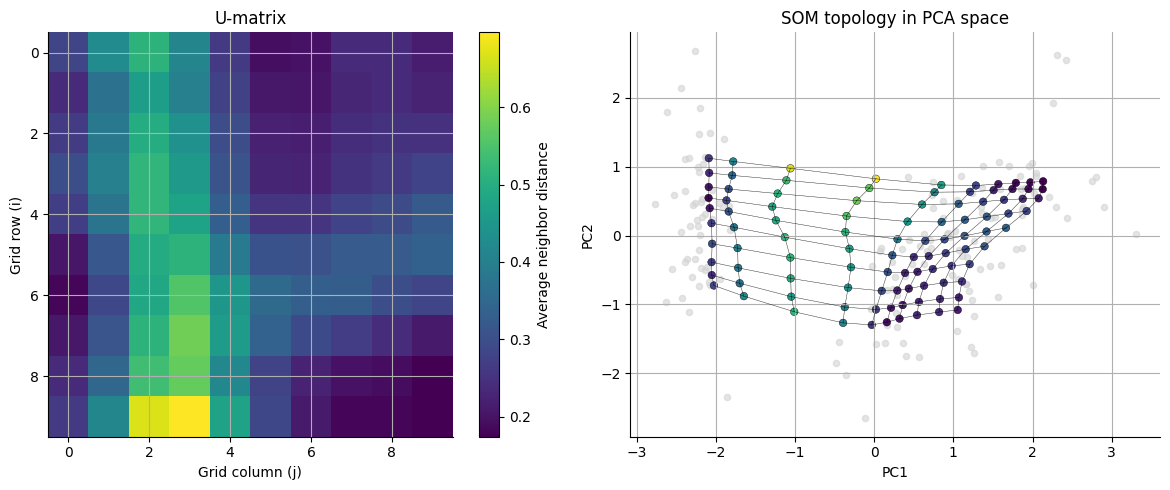

In [12]:
grid_m, grid_n = som.m, som.n

W2 = weights_pca.reshape(grid_m, grid_n, 2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
im = ax.imshow(U, cmap="viridis", origin="upper")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Average neighbor distance")

ax.set_title("U-matrix")
ax.set_xlabel("Grid column (j)")
ax.set_ylabel("Grid row (i)")


ax = axes[1]
ax.scatter(X_pca[:, 0], X_pca[:, 1], c="lightgrey", s=20, alpha=0.6, label="Iris data")

directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]


for i in range(grid_m):
    for j in range(grid_n):
        x_ij, y_ij = W2[i, j]
        for di, dj in directions:
            ni, nj = i + di, j + dj
            if 0 <= ni < grid_m and 0 <= nj < grid_n:
                x_n, y_n = W2[ni, nj]
                ax.plot([x_ij, x_n], [y_ij, y_n], "-k", linewidth=0.3, alpha=0.5)


norm = Normalize(vmin=U.min(), vmax=U.max())
cmap = plt.cm.viridis

U_flat = U.flatten()
colors_flat = cmap(norm(U_flat))

ax.scatter(
    W2[:, :, 0].ravel(),
    W2[:, :, 1].ravel(),
    c=colors_flat,
    s=30,
    edgecolor="k",
    linewidth=0.3,
    label="SOM neurons",
)

ax.set_title("SOM topology in PCA space")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()

##
##    analysis is not I wrote that under todo 
##

**part 7: Quantization error**

Quantization error is the average distance between each input to its BMU. Below, we run train SOM with 5 different grid sizes and print the quantization error.

**TODO**: What trend do you observe in the printed values? Explain why this happens.

In [ ]:
def quantization_error(data, som):
    total_dist = 0.0
    for x in data:
        i, j = som.find_bmu(x)
        w = som.weights[i, j]
        total_dist += np.linalg.norm(x - w)
    return total_dist / data.shape[0]


np.random.seed(42)
topology_config = [(3, 3), (5, 5), (8, 8), (10, 10), (15, 15)]
for m, n in topology_config:
    net = SOM(m=m, n=n, dim=X_scaled.shape[1], lr0=0.5, n_epochs=60)
    net.train(X_scaled)
    qe = quantization_error(X_scaled, net)
    print(f"Quantization error for config {(x_neurons, y_neurons)}: {qe:.4f}")

# Section B: Hopfield Networks

**Part 1: Plotting functions**

In [ ]:
np.random.seed(42)


def plot_pattern(pattern, title=None, ax=None):
    """
    Visualize a single 10x10 bipolar pattern.
    """
    if ax is None:
        _, ax = plt.subplots()
    img = (pattern.reshape(10, 10) + 1) / 2.0
    ax.imshow(img, cmap="gray_r", interpolation="nearest")
    ax.axis("off")
    if title is not None:
        ax.set_title(title)


def plot_pattern_triplet(original, corrupted, recalled, titles=None):
    if titles is None:
        titles = ["Original", "Corrupted", "Recalled"]
    _, axes = plt.subplots(1, 3, figsize=(8, 3))
    plot_pattern(original, title=titles[0], ax=axes[0])
    plot_pattern(corrupted, title=titles[1], ax=axes[1])
    plot_pattern(recalled, title=titles[2], ax=axes[2])
    plt.tight_layout()
    plt.show()

**Part 2: Digit Visualization**

Plot the 3 digits 0, 1, and 8.

In [ ]:
digit_patterns = np.load("digits.npy")  # shape (3,100)
digit_labels = ["0", "1", "8"]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, lbl in enumerate(digit_labels):
    plot_pattern(digit_patterns[i], title=lbl, ax=axes[i])
plt.tight_layout()
plt.show()

**Part 3: Weight Matrix Calculation**

**TODO**: Complete the implementation of `compute_weights`.

In [ ]:
def compute_weights(patterns):
    """
    patterns has shape shape (P, N) with bipolar values
    returns: W (N,N)
    """
    # TODO: Implement the weight matrix (remember to set the diagonal to zero)
    pass


W = compute_weights(digit_patterns)
print("W shape:", W.shape)

**Part 4: Update Rules**

Hopfield networks could be updated in two different manners: _Synchronous_ and _Asynchronous_.

**TODO**: Complete the implementation of `sgn`, `update_sync` and `update_async` methods below.

In [ ]:
def sgn(x):
    # TODO: Implement the sign() function
    pass


def update_sync(x0, W, max_steps=50):
    """
    Synchronous update rule for Hopfield network.

    x0: initial state (N,) with values in {-1, +1}
    W: weight matrix (N, N)
    max_steps: maximum number of synchronous update steps

    Returns:
        traj: list of states (each is an array of shape (N,))
              including the initial state as traj[0].
    """
    # TODO
    pass


def update_async(x0, W, max_sweeps=50):
    """
    Asynchronous update rule for Hopfield network.

    x0: initial state (N,) with values in {-1, +1}
    W: weight matrix (N, N)
    max_steps: maximum number of updates over all neurons

    Returns:
        traj: list of states (each is an array of shape (N,))
              including the initial state as traj[0].
    """
    # TODO
    pass

**Part 5: Recall Experiment**

Apply 3 types of noise to the stored patterns: a) random bit flipping, b) erasing the bottom half of the digit, and c) erasing the right half of the digit. Then, use the Hopfield network to recall a pattern.

**TODO**: In which cases has the network recalled the correct patterns and in which cases has it failed?

In [ ]:
def flip_bits(x, p):
    mask = np.random.rand(len(x)) < p
    x2 = x.copy()
    x2[mask] *= -1
    return x2


selected_digits = [0, 1, 2]  # corresponds to indices of ["0","1","8"]
noise_types = ["bitflip", "bottom", "right"]

fig, axes = plt.subplots(
    len(selected_digits) * 3, 2, figsize=(6, 2.2 * len(selected_digits) * 3)
)

row = 0
for idx in selected_digits:
    x_orig = digit_patterns[idx]
    label = digit_labels[idx]

    for noise in noise_types:
        if noise == "bitflip":
            noisy = flip_bits(x_orig, p=0.05)

        elif noise == "bottom":
            img = x_orig.reshape(10, 10).copy()
            img[5:, :] = -1
            noisy = img.reshape(-1)

        elif noise == "right":
            img = x_orig.reshape(10, 10).copy()
            img[:, 5:] = -1
            noisy = img.reshape(-1)

        traj = update_async(noisy, W, max_sweeps=50)
        recalled = traj[-1]

        axL = axes[row, 0]
        axR = axes[row, 1]

        plot_pattern(noisy, title=f"{label} ({noise}) noisy", ax=axL)
        plot_pattern(recalled, title=f"Recalled", ax=axR)

        row += 1

plt.tight_layout()
plt.show()

**Part 6: Energy of States**

Each stored pattern in a Hopfield network has an energy. The lower the energy of a state, the stronger of an attractor it is.

**TODO**: Complete the imlpementation of `energy`.

In [ ]:
def energy(x, W):
    # TODO: Compute the energy of state x for a given weight matrix W
    pass


for i in range(3):
    print(f"Energy of digit {digit_labels[i]}:, {energy(digit_patterns[i], W):.2f}")

**Part 7: Spurious Patterns**

Now, we are going to find (almost) all of the spurious patterns stored inside the Hopfield network.

**TODO**: Run the cell below and answer the questions:
- Are there any spurious patterns?
- Compare the energy of stored and spurious patterns.
- Explain why some of the noisy digits in **part 6** were recalled uncorrectly (if any).

In [ ]:
def discover_attractors(W, max_samples=5000, patience=500, max_steps=50):
    N = W.shape[0]
    attractors = []
    no_new_count = 0

    for _ in range(max_samples):
        x0 = np.random.choice([-1, 1], size=N)
        x_final = update_async(x0, W, max_sweeps=max_steps)[-1]

        is_new = True
        for a in attractors:
            if np.array_equal(a, x_final):
                is_new = False
                break

        if is_new:
            attractors.append(x_final.copy())
            no_new_count = 0
        else:
            no_new_count += 1

        if no_new_count >= patience:
            break

    return attractors


attractors = discover_attractors(W, max_samples=5000, patience=500, max_steps=50)
print(f"Discovered {len(attractors)} distinct attractors.")


def classify_attractor(a, patterns, labels):
    for i in range(patterns.shape[0]):
        if np.array_equal(a, patterns[i]):
            return ("stored", labels[i])
        if np.array_equal(a, -patterns[i]):
            return ("neg_stored", labels[i])
    return ("spurious", None)


classified = [classify_attractor(a, digit_patterns, digit_labels) for a in attractors]

for idx, a in enumerate(attractors):
    kind, lab = classified[idx]
    E = energy(a, W)
    if lab is None:
        print(f"Attractor {idx}: {kind}, E = {E:.3f}")
    else:
        print(f"Attractor {idx}: {kind} ({lab}), E = {E:.3f}")


stored_indices = [i for i, c in enumerate(classified) if c[0] == "stored"]
neg_stored_indices = [i for i, c in enumerate(classified) if c[0] == "neg_stored"]
spurious_indices = [i for i, c in enumerate(classified) if c[0] == "spurious"]


def show_attractor_group(indices, title_prefix):
    if not indices:
        print(f"No {title_prefix.lower()} attractors found.")
        return
    n = len(indices)
    _, axes = plt.subplots(1, n, figsize=(3 * n, 3))
    if n == 1:
        axes = [axes]
    for k, idx in enumerate(indices):
        a = attractors[idx]
        kind, lab = classified[idx]
        E = energy(a, W)

        if lab is None:
            t = f"{title_prefix} {idx}\nE = {E:.2f}"
        else:
            t = f"{title_prefix} {idx} ({lab})\nE = {E:.2f}"

        plot_pattern(a, title=t, ax=axes[k])
    plt.tight_layout()
    plt.show()


# Original patterns as attractors
show_attractor_group(stored_indices, "Stored")

# Negated stored patterns
show_attractor_group(neg_stored_indices, "Neg-stored")

# Spurious patterns
show_attractor_group(spurious_indices, "Spurious")